In [992]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import model_selection
import xgboost as xgb

In [993]:
# data from Kaggle competition "Titanic: Machine Learning from Disaster"
# https://www.kaggle.com/c/titanic/data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [994]:
Y_train = train.Survived
test_id = test.PassengerId

In [995]:
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [996]:
train_test = pd.concat([train, test])
train_test = train_test.drop(['Survived', 'PassengerId', 'Name', 'Ticket'], axis = 1)
print 'shape: '
print train_test.shape, train.shape, test.shape
print '~~~~~~~~~~~~~'
print 'type'
print train_test.dtypes
print '~~~~~~~~~~~~~'
print 'No. of Nans'
print train_test.isnull().sum()
print '~~~~~~~~~~~~~'
train_test.head(2)

shape: 
(1309, 8) (891, 12) (418, 11)
~~~~~~~~~~~~~
type
Age         float64
Cabin        object
Embarked     object
Fare        float64
Parch         int64
Pclass        int64
Sex          object
SibSp         int64
dtype: object
~~~~~~~~~~~~~
No. of Nans
Age          263
Cabin       1014
Embarked       2
Fare           1
Parch          0
Pclass         0
Sex            0
SibSp          0
dtype: int64
~~~~~~~~~~~~~


,Age,Cabin,Embarked,Fare,Parch,Pclass,Sex,SibSp
0,22.0,NaN,S,7.2500,0,3,male,1
1,38.0,C85,C,71.2833,0,1,female,1


In [997]:
print 'fill NaNs with mean or mode for object type'
train['Age'].fillna(train['Age'].mean(), inplace=True)
train['Fare'].fillna(train['Fare'].mean(), inplace=True)
train['Embarked'].fillna(train.Embarked.value_counts().index[0], inplace=True)
test['Age'].fillna((test['Age'].mean()), inplace=True)
test['Fare'].fillna(test['Fare'].mean(), inplace=True)
test['Embarked'].fillna(train.Embarked.value_counts().index[0], inplace=True)
train_test = pd.concat([train, test])
train_test = train_test.drop(['Survived', 'Cabin', 'PassengerId', 'Name', 'Ticket'], axis = 1)

print 'No. of Nans'
print train_test.isnull().sum()
train_test.head(2)

fill NaNs with mean or mode for object type
No. of Nans
Age         0
Embarked    0
Fare        0
Parch       0
Pclass      0
Sex         0
SibSp       0
dtype: int64


,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp
0,22.0,S,7.2500,0,3,male,1
1,38.0,C,71.2833,0,1,female,1


In [998]:
survivors = train.loc[train['Survived'] == 1]
print 'No. of survivors: %r' %  survivors.Survived.value_counts()[1]
victims = train.loc[train['Survived'] == 0]
print 'No. of victims: %r' % victims.Survived.value_counts()[0]

No. of survivors: 342
No. of victims: 549


In [999]:
def histogram1(train, columns):
    for col in columns:
        ax = sns.countplot(x="Survived", hue=col, data=train)
        ax.set_title(col)
        plt.show()

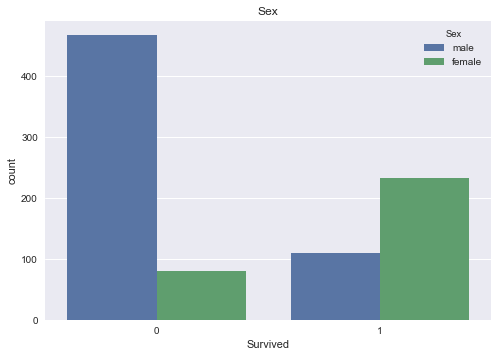

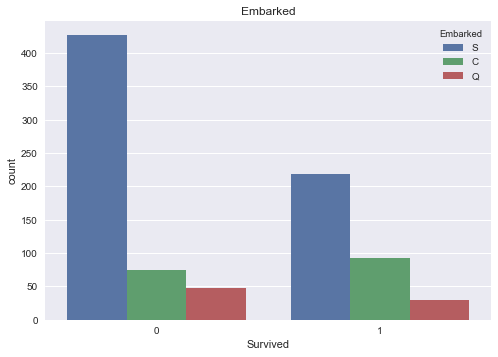

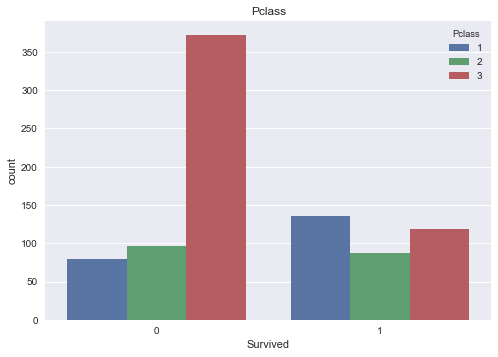

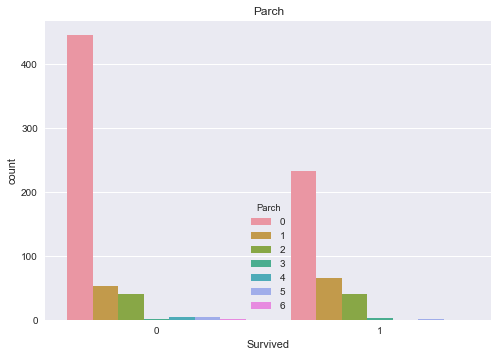

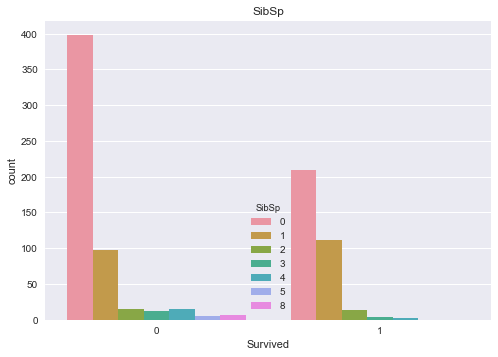

In [1000]:
columns1 = ['Sex', 'Embarked', 'Pclass', 'Parch', 'SibSp']
histogram1(train, columns1)

In [1001]:
print 'process categorical features: ["Sex", "Embarked", "Pclass", "Parch", "SibSp"]'
train_test = pd.concat([train, test])
train_test = train_test.drop(['Survived', 'Cabin', 'PassengerId', 'Name', 'Ticket'], axis = 1)
sex = pd.get_dummies(train_test.Sex)
embarked = pd.get_dummies(train_test.Embarked, prefix='Embarked')
pclass = pd.get_dummies(train_test.Pclass, prefix='Pclass')
train_test.loc[train_test['Parch'] > 2, 'Parch'] = 3
parch = pd.get_dummies(train_test.Parch, prefix='Parch')
train_test.loc[train_test['SibSp'] > 1, 'SibSp'] = 2
sibsp = pd.get_dummies(train_test.SibSp, prefix='SibSp')
train_test = pd.concat([train_test, sex, embarked, pclass, parch, sibsp], axis = 1)
train_test = train_test.drop(["Sex", "Embarked", "Pclass", "Parch", "SibSp"], axis = 1)
train_test.head(2)

process categorical features: ["Sex", "Embarked", "Pclass", "Parch", "SibSp"]


,Age,Fare,female,male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Parch_0,Parch_1,Parch_2,Parch_3,SibSp_0,SibSp_1,SibSp_2
0,22.0,7.2500,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0
1,38.0,71.2833,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0


In [1002]:
def histogram2(survivors, victims, columns):
    for col in columns:
        survivor = survivors[col]
        victim = victims[col]
        bins = 20
        plt.hist(survivor, bins, alpha=0.6, facecolor='green', label='survivors')
        plt.hist(victim, bins, alpha=0.6, facecolor='red', label='victims')
        plt.title(col)
        plt.legend(loc='upper center')
        plt.show()

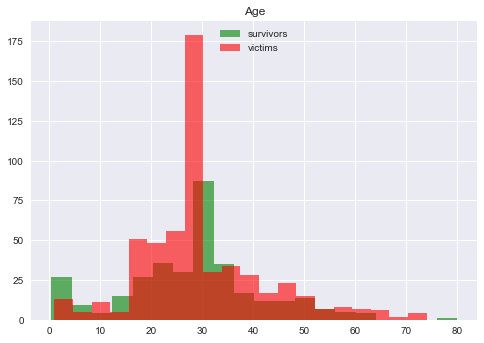

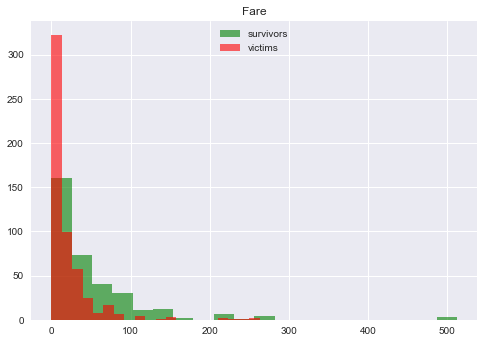

In [1003]:
columns2 = ['Age', 'Fare']
histogram2(survivors, victims, columns2)

In [1004]:
print 'process numerical features: ["Age", "Fare"]'
ages = train_test.Age
train_test['children'] = [1 if age <= 18.0 else 0 for age in ages]
train_test['adult'] = [1 if 18.0 < age <= 40.0 else 0 for age in ages]
train_test['elder'] = [1 if age > 40.0 else 0 for age in ages]

fares = train_test.Fare
train_test['cheap'] = [1 if fare <= train.Fare.median() else 0 for fare in fares]
train_test['expensive'] = [1 if fare > train.Fare.median() else 0 for fare in fares]
train_test = train_test.drop(["Age", "Fare"], axis = 1)
train_test.head(2)

process numerical features: ["Age", "Fare"]


,female,male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Parch_0,Parch_1,Parch_2,Parch_3,SibSp_0,SibSp_1,SibSp_2,children,adult,elder,cheap,expensive
0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0
1,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1


In [1005]:
# def normalize(columns):
#     for col in columns:
#         mu = train[col].mean()
#         sigma = train[col].std()
#         train_test[col] = (train[col] - train[col].mean())/train[col].std()
        
# print 'normalize columns ["Age", "Fare"]: '
# columns_to_normalize = ['Age', 'Fare']
# normalize(columns_to_normalize)
# train_test.describe()

In [1006]:
X_train = train_test[:len(train)]
X_test = train_test[len(train):]
print X_train.shape, X_test.shape

(891, 20) (418, 20)


In [1007]:
print X_train.shape, Y_train.shape
X_train, X_cv, Y_train, Y_cv = model_selection.train_test_split(X_train, Y_train, test_size=0.3)
print X_train.shape, Y_train.shape
print X_cv.shape, Y_cv.shape

(891, 20) (891,)
(623, 20) (623,)
(268, 20) (268,)


# Logistic regression

In [1008]:
def sigmoid(x):
    x = np.array(x)
    return 1/(1+np.exp(-x))

In [1009]:
def logistic_regression_cost_and_gradient(X_train, Y_train, theta, la):
    # return cost J and gradient of theta in grad
    m = len(Y_train)
    X = X_train.copy()
    X.insert(0, 'Bias', 1)
    X = np.array(X)
    Y = np.array(Y_train)
    h_theta = sigmoid(np.dot(X, theta))
    J = -(np.dot(Y, np.log(h_theta)) + np.dot(1-Y, np.log(1-h_theta))) / m + np.dot(theta[1:], theta[1:])*la / (2*m)
    grad = np.dot(X.transpose(), h_theta - Y) / m + theta*la / m
    grad[0] = grad[0] - theta[0]*la / m     
    return [J, grad]

In [1010]:
def logistic_regression_model(X_train, Y_train, theta, la = 1, alpha = 0.1, epsilon = 10.0**(-5), max_iterators = 10**4):
    # return cost J and optimal theta 
    [J, grad] = logistic_regression_cost_and_gradient(X_train, Y_train, theta, la)
    cost = [J]
    for i in range(max_iterators):
        theta = theta - alpha * grad
        [J, grad] = logistic_regression_cost_and_gradient(X_train, Y_train, theta, la)
        if abs(cost[-1] - J) < epsilon:
            break
        cost.append(J)
        
    plt.plot(cost)
    plt.title('alpha = %r, lambda = %r'% (alpha, la))
    plt.xlabel('No. of iterations')
    plt.ylabel('Cost function J')
    plt.show()
    
    return [J, theta]

In [1011]:
def logistic_regression_cross_validation(X_train, X_cv, Y_train, Y_cv, lambdas, alphas):
    init_theta = np.zeros(X_train.shape[1] + 1)
    alpha_best = alphas[0]
    lambda_best = lambdas[0]
    theta_best = init_theta
    J_best = float("inf")
    for alpha in alphas:
        Js = []
        J_train = []
        J_cv = []
        thetas = []
        for i in range(len(lambdas)):
            [J, theta] = logistic_regression_model(X_train, Y_train, init_theta, lambdas[i], alpha)
            Js.append(J)
            [J_train_i, grad_train] = logistic_regression_cost_and_gradient(X_train, Y_train, theta, 0)
            if len(J_train) > 0 and J_train[-1] > J_train_i:
                break
            J_train.append(J_train_i)
            [J_cv_i, grad_cv] = logistic_regression_cost_and_gradient(X_cv, Y_cv, theta, 0)
            J_cv.append(J_cv_i)
            if len(J_train) > 0 and J_train[-1] > J_cv[-1]:
                break
            if len(J_cv) == 2 and J_cv[1] > J_cv[0]:
                break
            thetas.append(theta)
        if len(thetas) != len(lambdas):
            continue

        plot_train, = plt.plot(lambdas, J_train, label='J_train')
        plot_cv, = plt.plot(lambdas, J_cv, label='J_cv')
        plt.title('Cross Validation')
        plt.xlabel('lambda')
        plt.ylabel('Cost function J')
        plt.legend([plot_train, plot_cv], ["J_train", "J_cv"])
        plt.show()
        
        idx = J_cv.index(min(J_cv))
        if idx != 0 and idx != len(J_cv) - 1:
            if Js[idx] < J_best:
                J_best = Js[idx]
                alpha_best = alpha
                lambda_best = lambdas[idx]
                theta_best = thetas[idx]
                print 'update parameters: '
                print 'cost = %r ' % J 
                print 'best alpha = %r' % alpha_best
                print 'best lambda = %r' % lambda_best
                print 'best theta = %r' % theta_best

    return [alpha_best, lambda_best, theta_best]

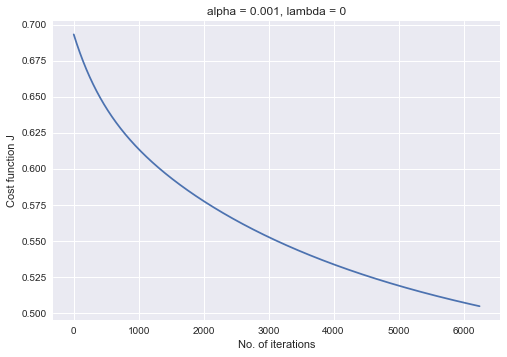

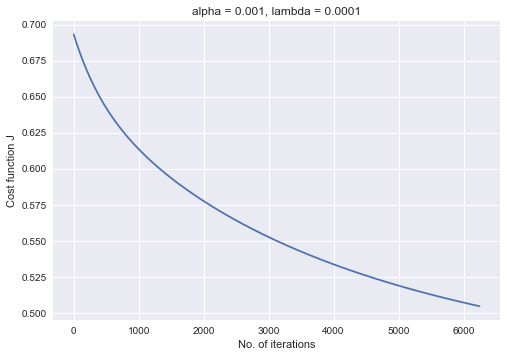

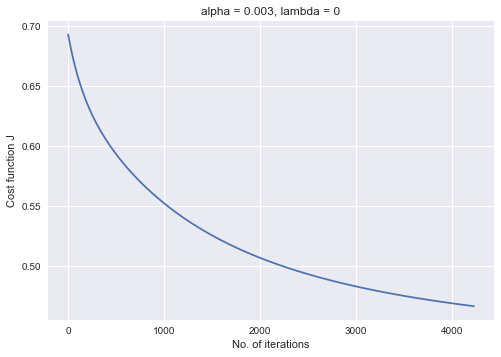

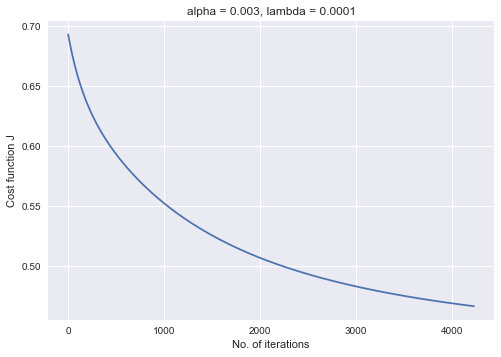

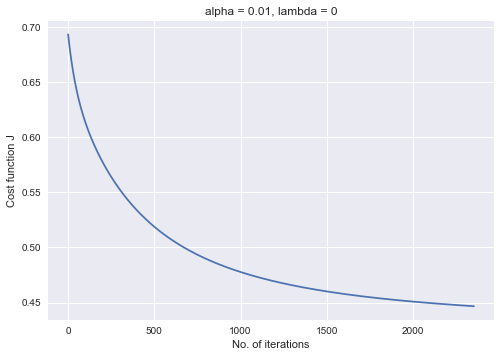

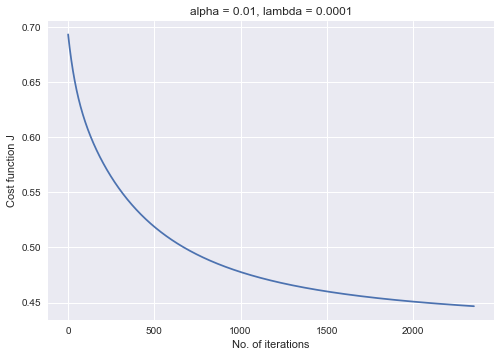

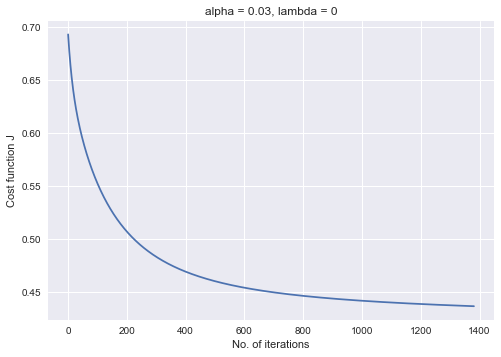

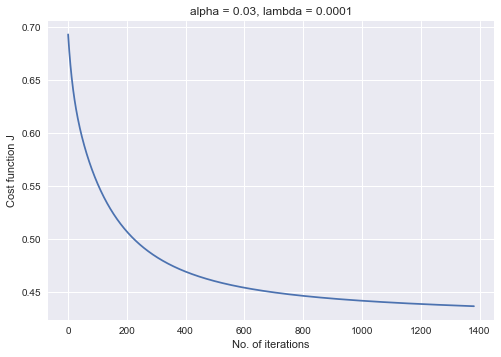

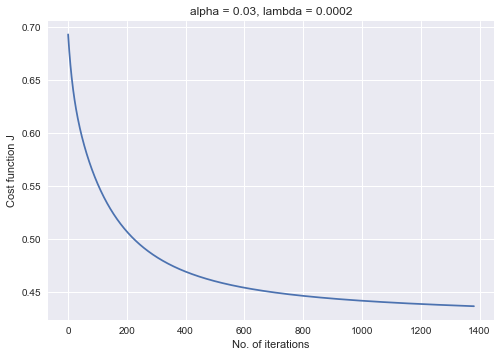

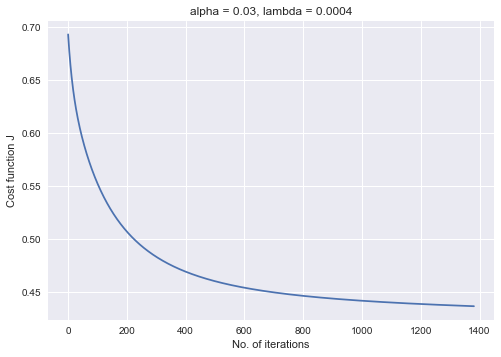

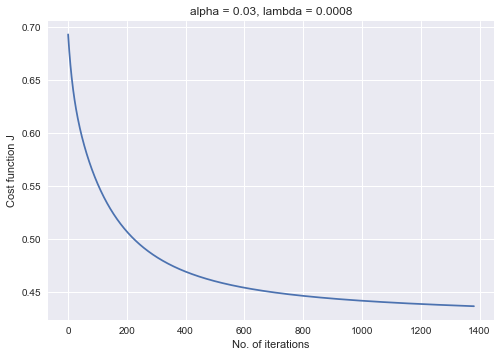

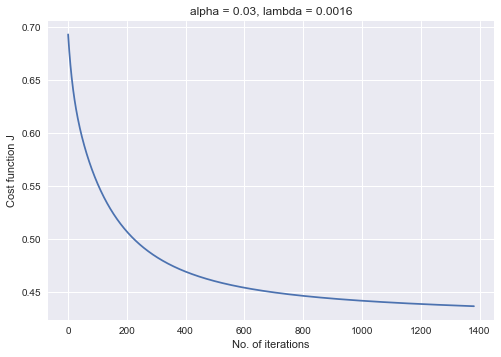

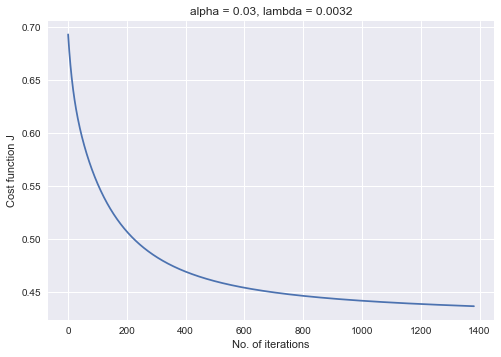

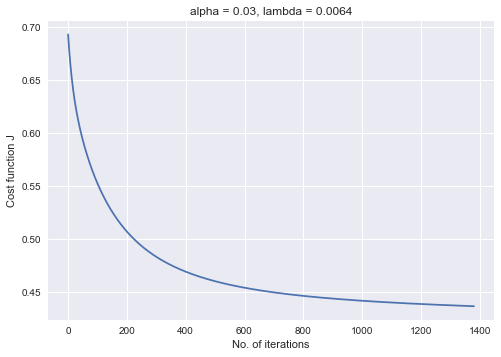

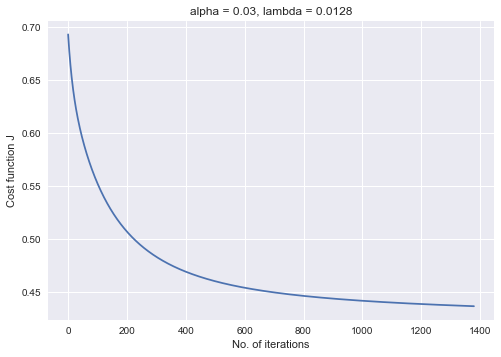

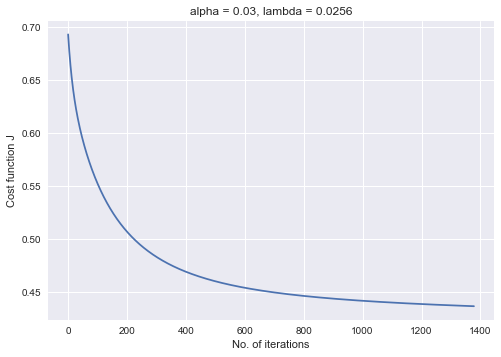

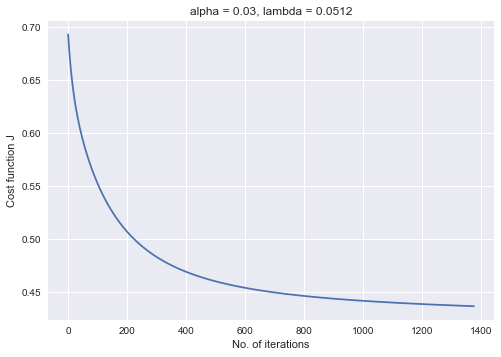

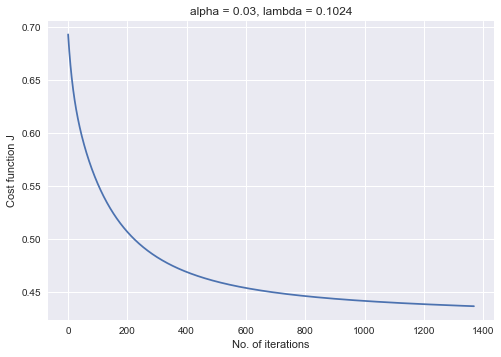

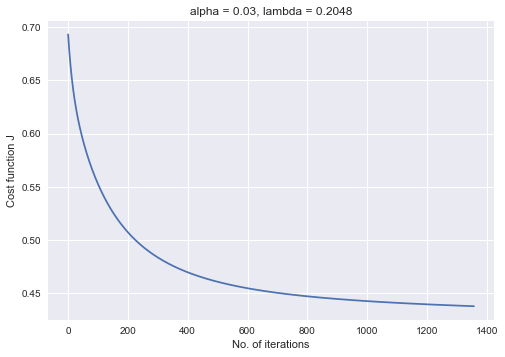

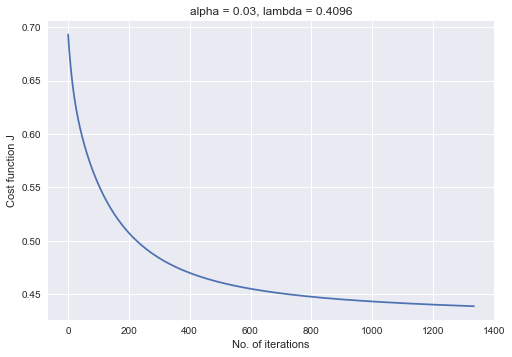

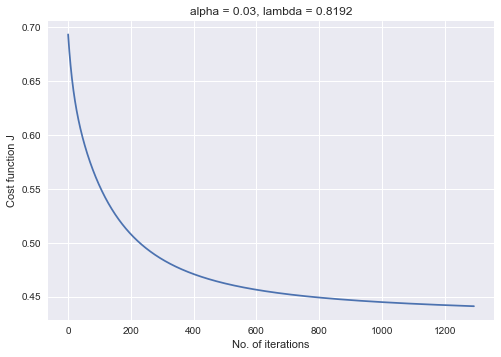

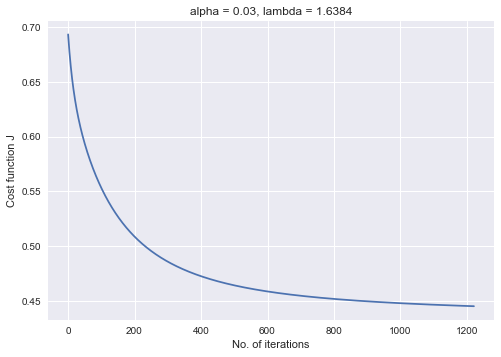

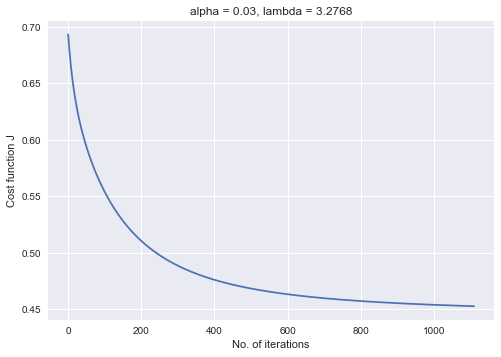

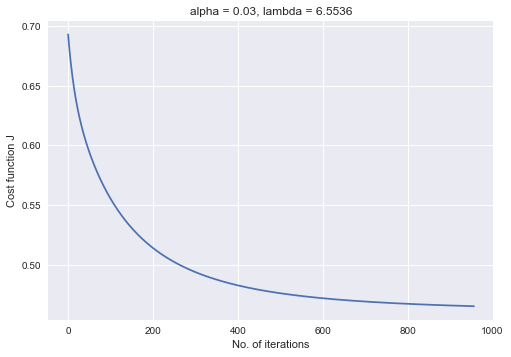

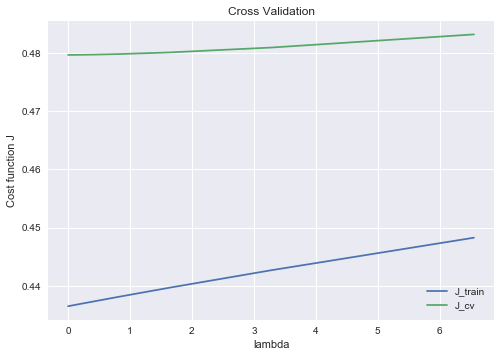

update parameters: 
cost = 0.46523579641497931 
best alpha = 0.03
best lambda = 0.0032
best theta = array([-0.02689213,  1.25559607, -1.28248327,  0.15677357,  0.03575138,
       -0.21941214,  0.53442978,  0.15634477, -0.71766174, -0.01392908,
        0.26652936, -0.09574302, -0.18374445,  0.29962897,  0.08236802,
       -0.40888418,  0.41307471, -0.06928625, -0.37067566, -0.22413977,
        0.19725258])


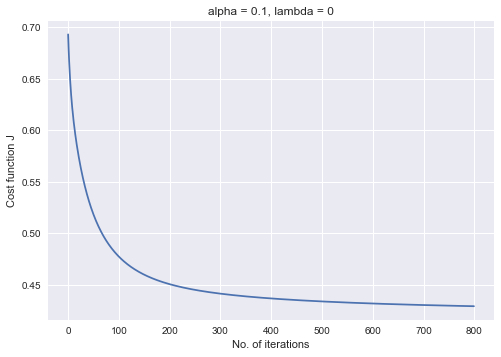

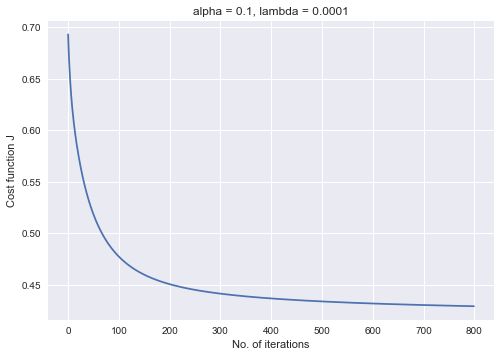

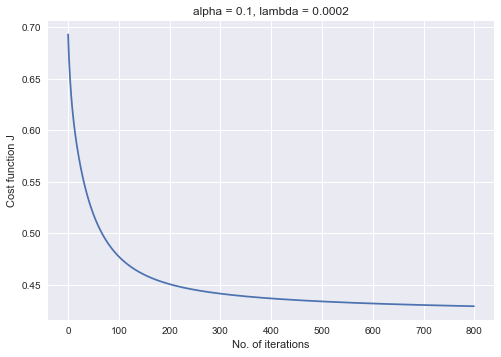

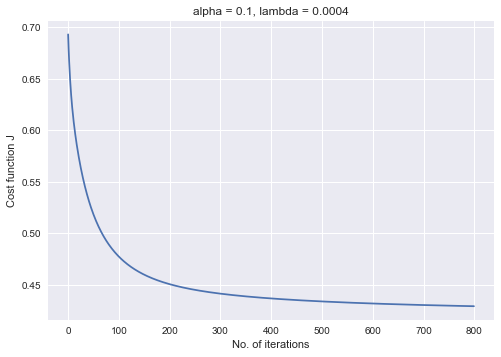

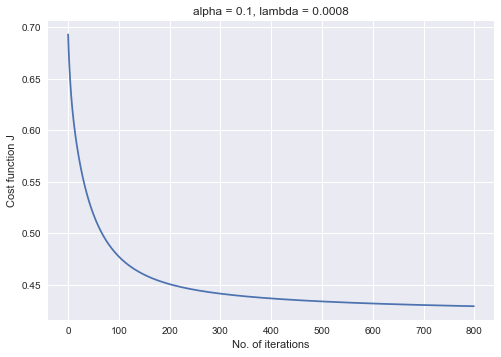

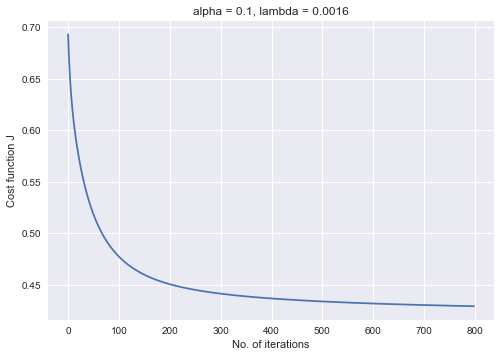

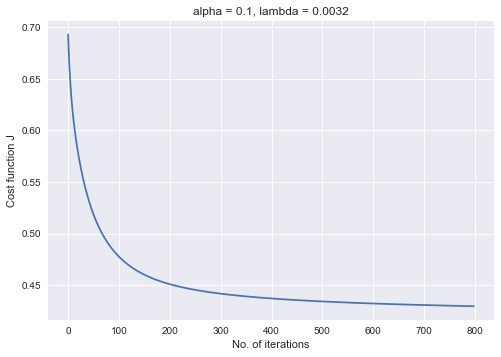

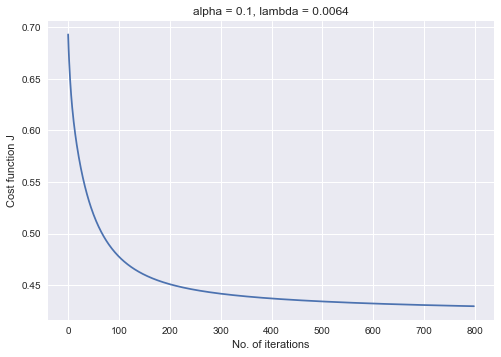

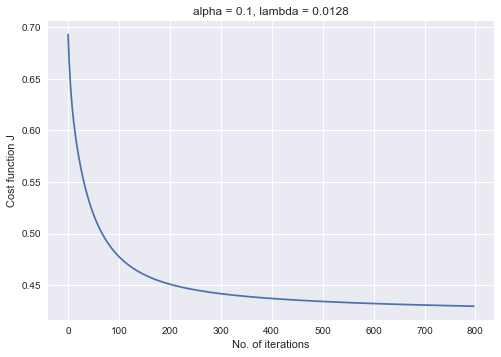

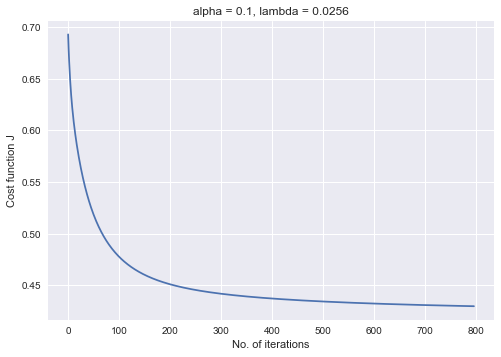

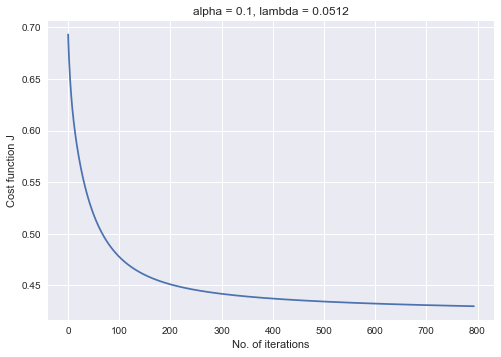

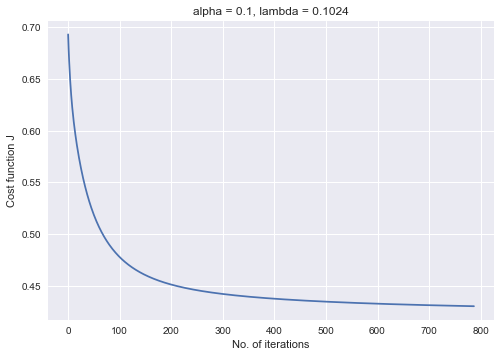

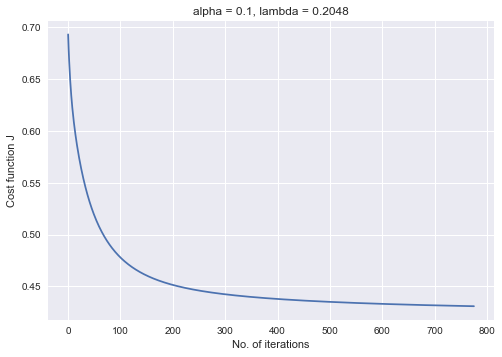

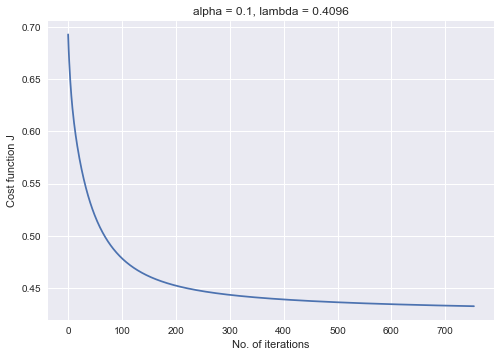

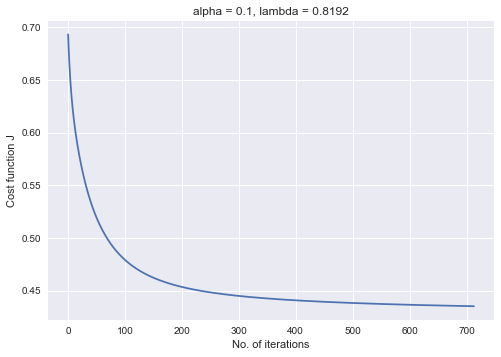

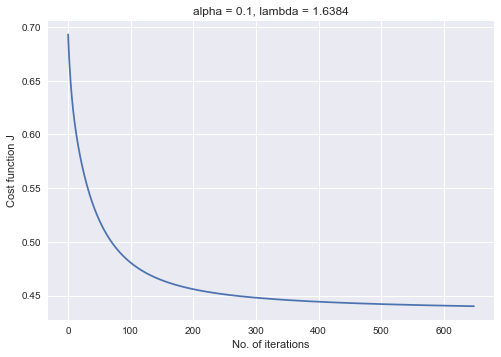

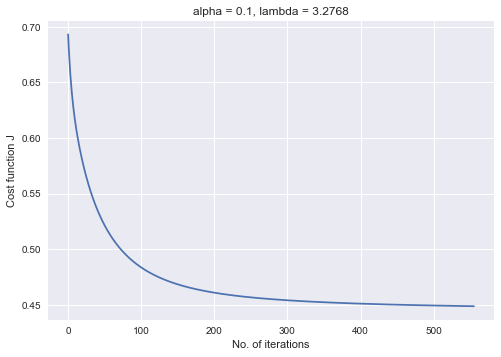

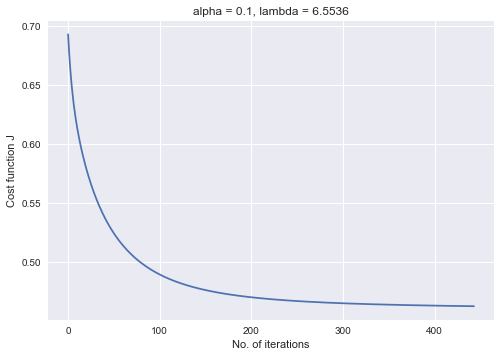

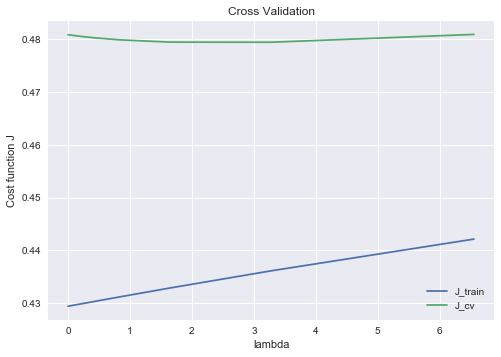

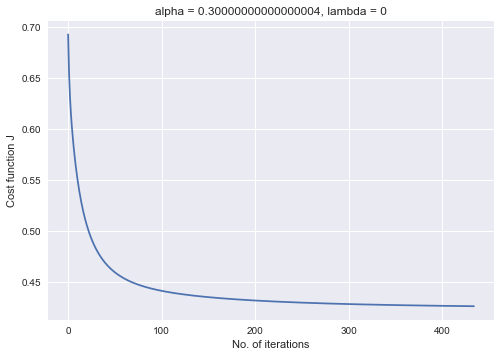

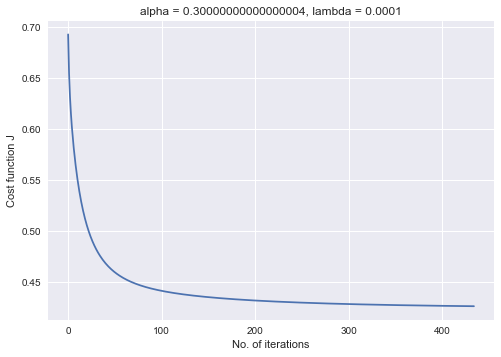

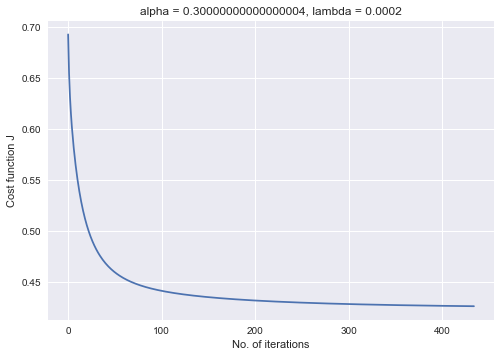

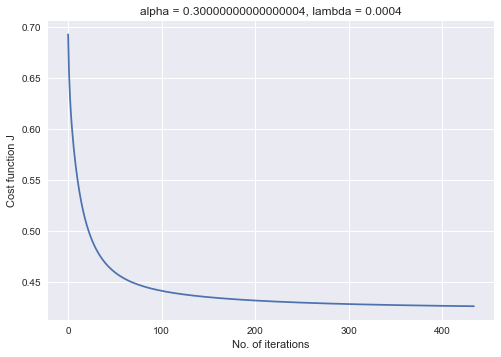

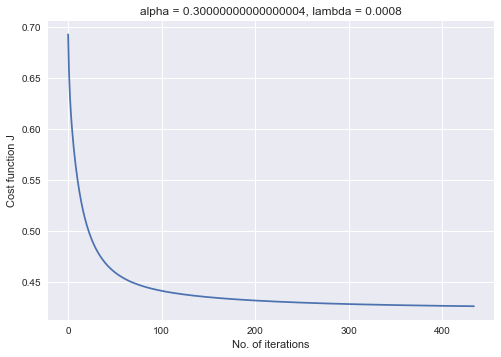

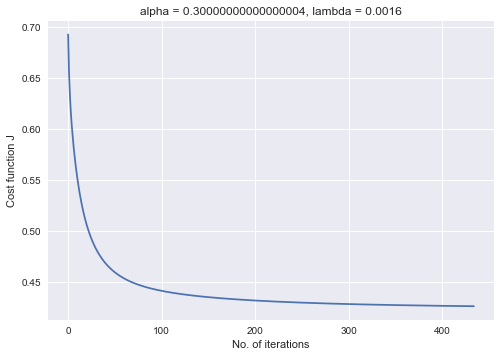

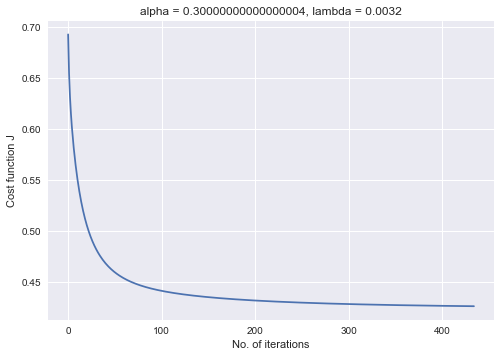

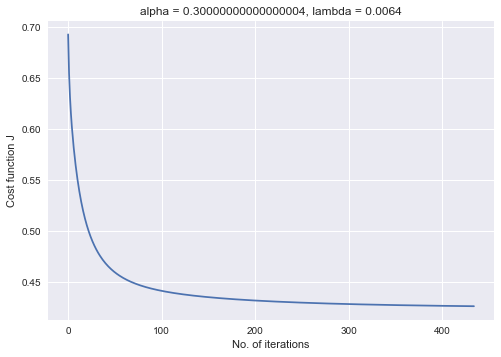

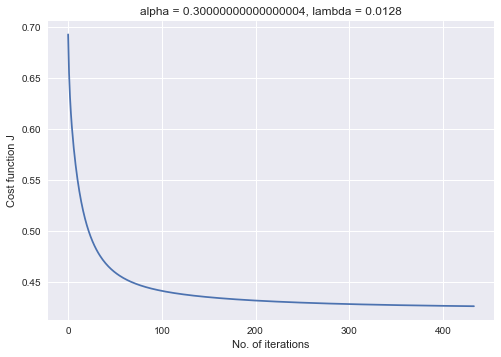

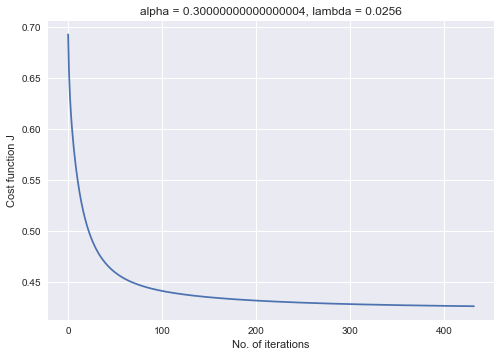

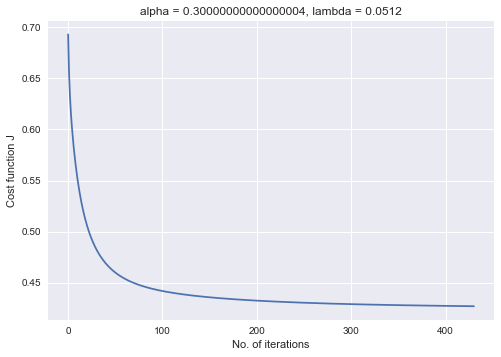

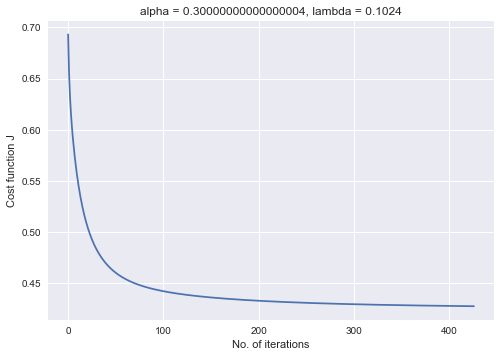

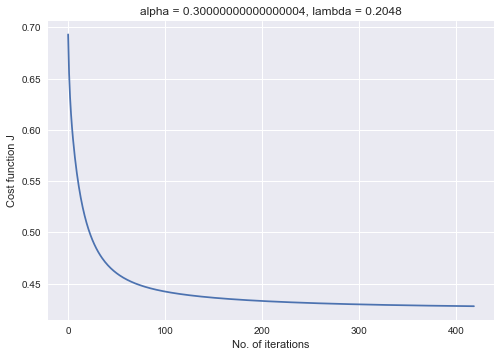

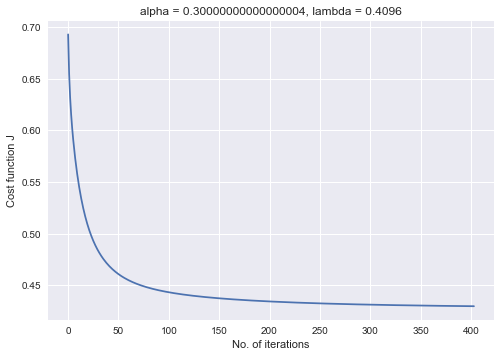

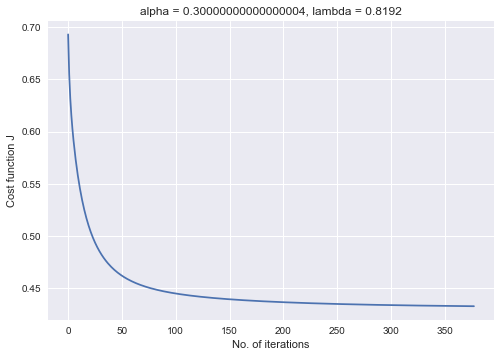

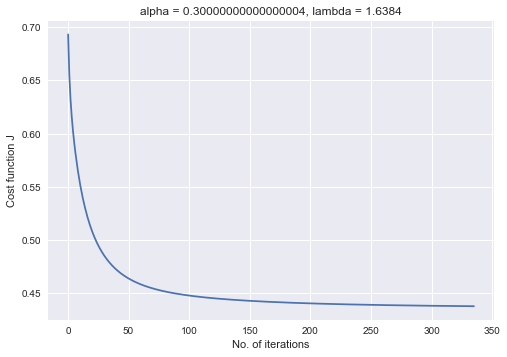

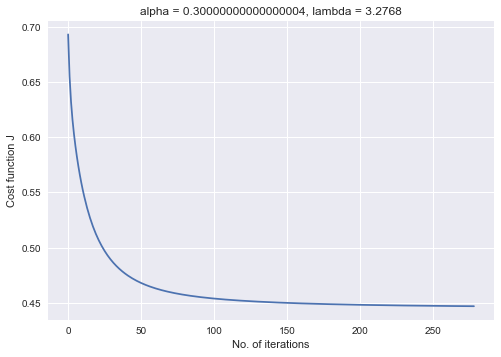

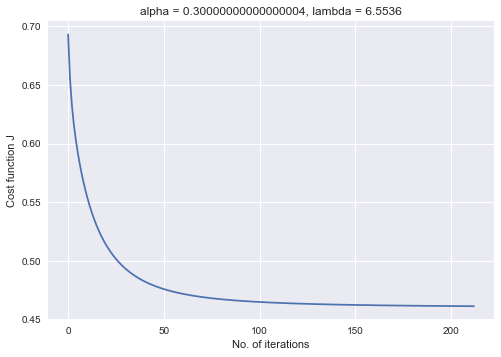

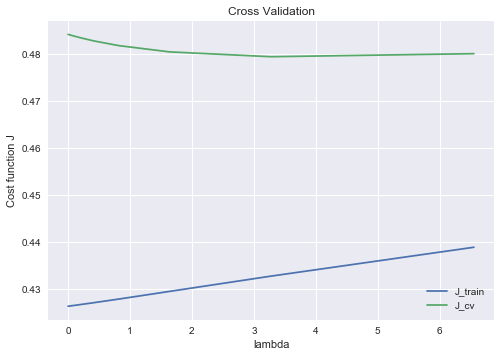

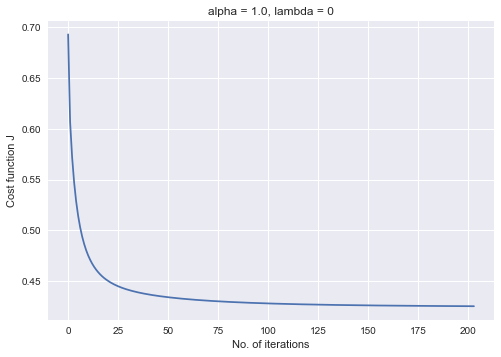

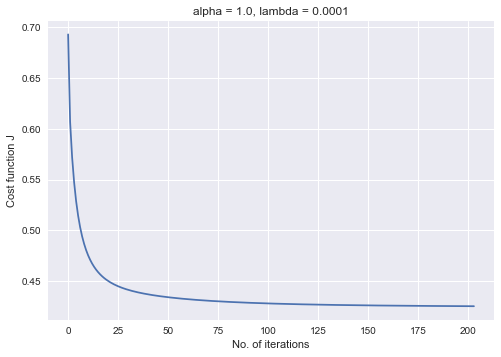

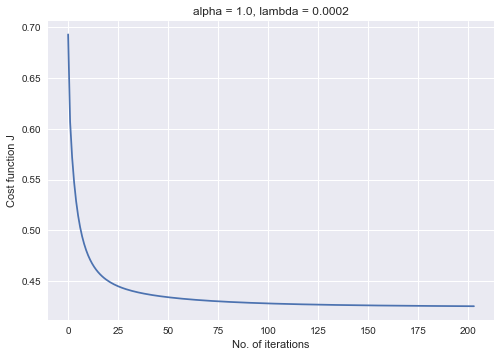

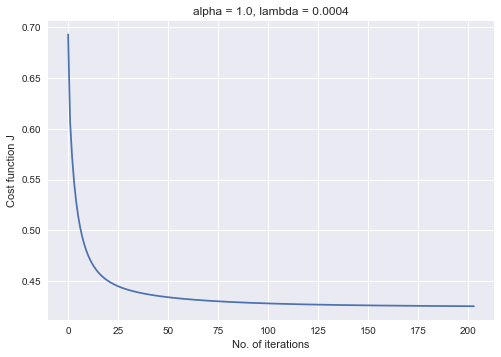

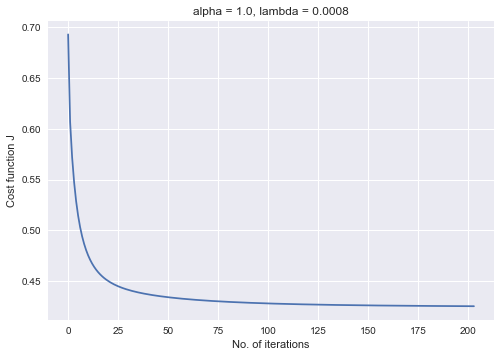

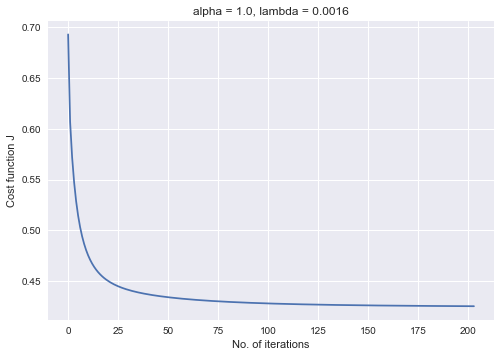

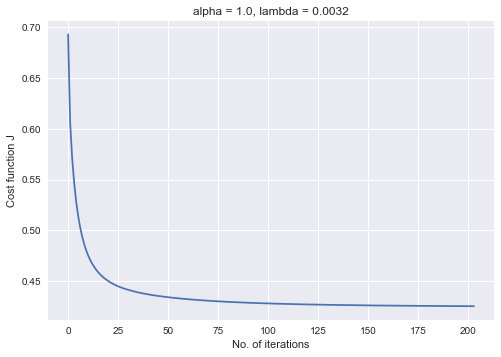

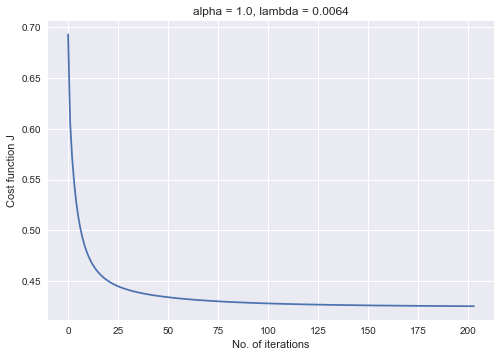

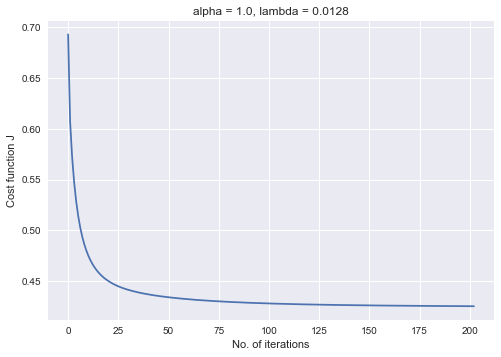

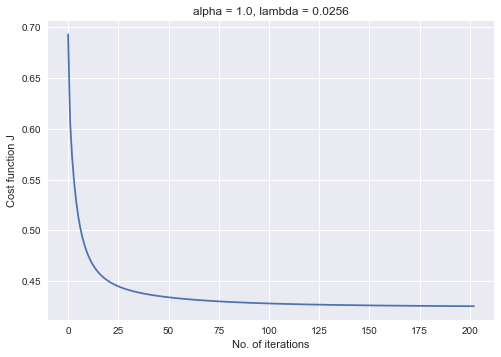

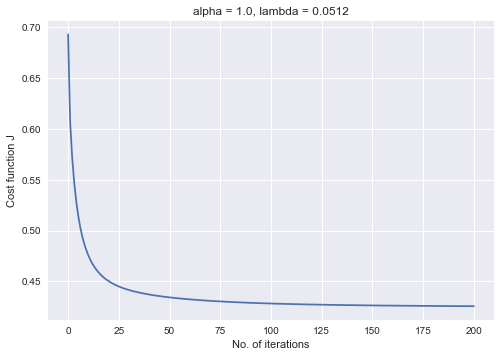

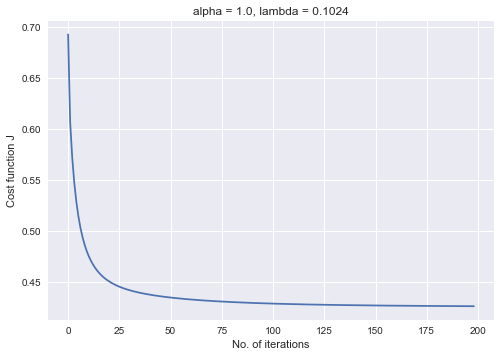

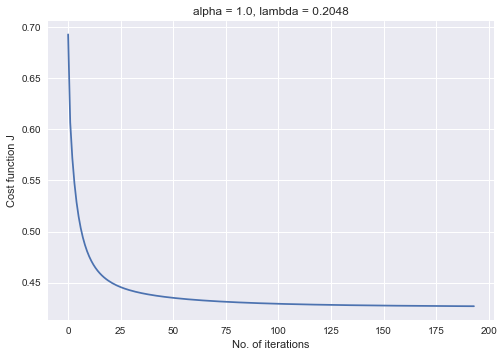

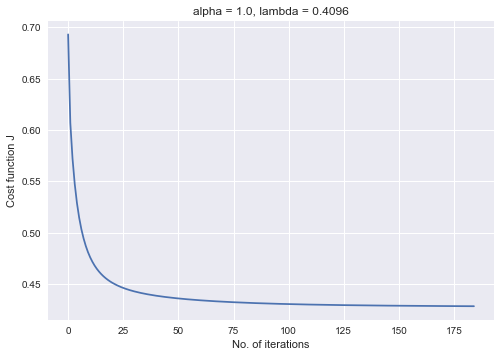

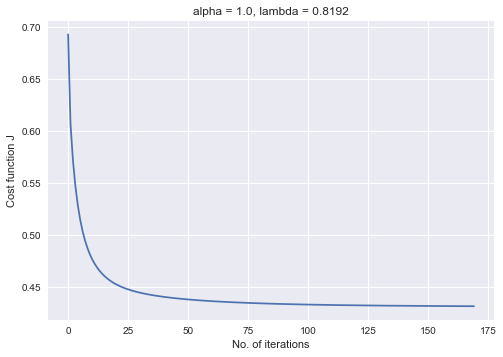

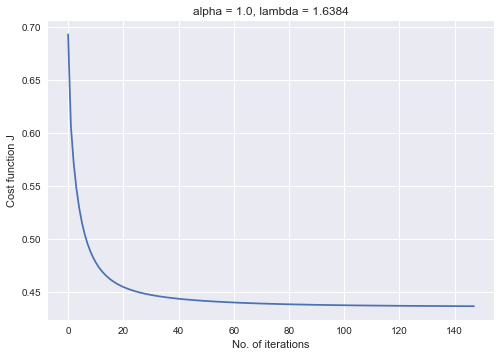

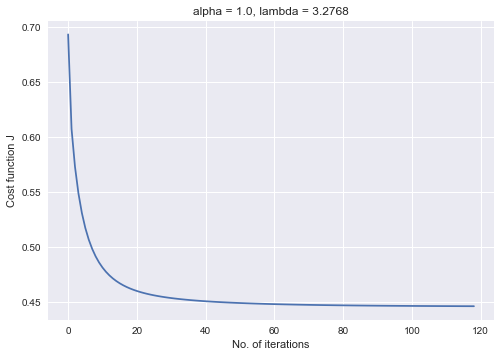

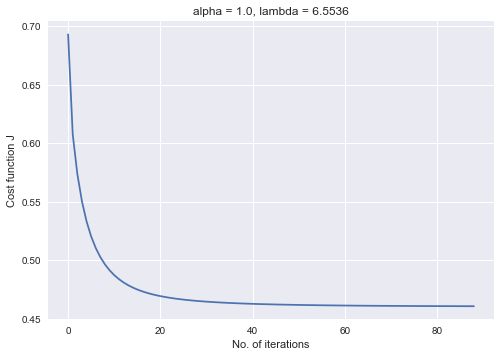

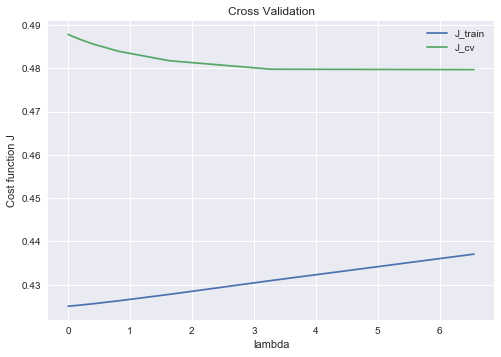

In [1012]:
alphas = [10.0**(i-3) for i in range(4)] + [3*10**(i-3) for i in range(3)]
alphas.sort()
lambdas = [10.0**(-4)*2**i for i in range(17)]
lambdas.insert(0, 0)
[alpha_best, lambda_best, theta_best] = logistic_regression_cross_validation(X_train, X_cv, Y_train, Y_cv, lambdas, alphas)

In [1013]:
print 'best alpha = %r' % alpha_best
print 'best lambda = %r' % lambda_best
print 'best theta = %r' % theta_best

best alpha = 0.03
best lambda = 0.0032
best theta = array([-0.02689213,  1.25559607, -1.28248327,  0.15677357,  0.03575138,
       -0.21941214,  0.53442978,  0.15634477, -0.71766174, -0.01392908,
        0.26652936, -0.09574302, -0.18374445,  0.29962897,  0.08236802,
       -0.40888418,  0.41307471, -0.06928625, -0.37067566, -0.22413977,
        0.19725258])


In [1014]:
def logistic_regression_predict(theta, X_test):
    X = X_test.copy()
    X.insert(0, 'Bias', 1)
    X = np.array(X)
    predict = sigmoid(np.dot(X, theta))
    return predict

In [1015]:
print 'predict result by logistic regression:'
y_predict_lr = logistic_regression_predict(theta_best, X_test)
y_predict = [1 if p > 0.5 else 0 for p in y_predict_lr]
# print len(test_id), len(y_predict_lr)
output_lr = pd.DataFrame({'PassengerId': test_id, 'Survived': y_predict})
print output_lr.Survived.value_counts()
# output_lr.to_csv('Titanic_lr.csv', index=False)
output_lr.head()

predict result by logistic regression:
0    269
1    149
Name: Survived, dtype: int64


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


# Xgboost

In [1016]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 6,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'binary:logistic',
    'eval_metric': 'rmse',
    'silent': 0
}

In [1017]:
dtrain = xgb.DMatrix(X_train, Y_train)
dcv = xgb.DMatrix(X_cv)
dtest = xgb.DMatrix(X_test)
xgboost_model = xgb.train(dict(xgb_params), dtrain, num_boost_round=1000)

In [1018]:
print 'predict result by xgboost:'
y_predict_xgb = xgboost_model.predict(dtest)
y_predict = [1 if p > 0.5 else 0 for p in y_predict_xgb]
# print len(test_id), len(y_predict_xgb)
output_xgb = pd.DataFrame({'PassengerId': test_id, 'Survived': y_predict})
print output_xgb.Survived.value_counts()
# output_xgb.to_csv('Titanic_xgb.csv', index=False)
output_xgb.head()

predict result by xgboost:
0    282
1    136
Name: Survived, dtype: int64


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


# Ensemble of the two models

In [1019]:
def f1_score(Y_cv_predict, Y_cv):
    tp = np.dot(Y_cv_predict, Y_cv)
    fp = np.dot(Y_cv_predict, 1 - Y_cv)
    fn = np.dot(1 - np.array(Y_cv_predict), Y_cv)

    precision = float(tp)/(tp + fp)
    recall = float(tp)/(tp + fn)
    f1 = 2*precision*recall/(precision + recall)
#     print tp, fp, fn, precision, recall, f1
    
    return f1

In [1020]:
Y_cv_lr = logistic_regression_predict(theta_best, X_cv)
Y_cv_lr = [1 if p > 0.5 else 0 for p in Y_cv_lr]
Y_cv_xgb = xgboost_model.predict(dcv)
Y_cv_xgb = [1 if p > 0.5 else 0 for p in Y_cv_xgb]
w1 = f1_score(Y_cv_lr, Y_cv)
w2 = f1_score(Y_cv_xgb, Y_cv)
w1 = round(w1 / (w1 + w2),3)
w2 = 1 - w1
print 'logistic_regression model weight w1 = %r' % w1
print 'xgboost model weight w2 = %r' % w2

logistic_regression model weight w1 = 0.493
xgboost model weight w2 = 0.507


In [1021]:
y_predict = w1 * y_predict_lr + w2 * y_predict_xgb
y_predict = [1 if p > 0.5 else 0 for p in y_predict]
# print len(test_id), len(y_predict)
output = pd.DataFrame({'PassengerId': test_id, 'Survived': y_predict})
print output.Survived.value_counts()
output.to_csv('Titanic.csv', index=False)
output.head()

0    269
1    149
Name: Survived, dtype: int64


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
